## Libs

In [94]:
import os
import torch
from torch.autograd import Variable

import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

from router import models
from tacotron2.text import text_to_sequence
from common.utils import load_wav_to_torch, to_gpu
from common.layers import TacotronSTFT
from configs import Config as hp

## Paths to checkpoints

In [95]:
taco_path = '/workspace/output/gst_lj/checkpoint_Tacotron2_1500'
wg_path   = '/workspace/output/sm_wg/checkpoint_WaveGlow_1750'

## Load models

In [96]:
taco_checkpoint = torch.load(taco_path, map_location='cpu')
wg_checkpoint = torch.load(wg_path, map_location='cpu')

In [97]:
t2 = models.get_model('Tacotron2', taco_checkpoint['config'], to_cuda=True)
wg = models.get_model('WaveGlow', wg_checkpoint['config'], to_cuda=True)

In [98]:
for model, checkpoint in [(t2, taco_checkpoint), (wg, wg_checkpoint)]:
    new_state_dict = {}
    for key, value in checkpoint['state_dict'].items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)

In [99]:
t2.eval()
wg.eval()
print('Done')

Done


## Set speaker and text

In [100]:
text = "hello. how are you today?"
speaker_id = 0

## Select inference type

In [101]:
inf_type = 'ref'

### Reference audio

In [102]:
ref_dir = '/workspace/training_data/linda_johnson/wavs'

In [103]:
os.listdir(ref_dir)

['LJ022-0041.wav',
 'LJ032-0121.wav',
 'LJ041-0091.wav',
 'LJ028-0107.wav',
 'LJ011-0047.wav',
 'LJ040-0189.wav',
 'LJ009-0283.wav',
 'LJ014-0199.wav',
 'LJ005-0101.wav',
 'LJ018-0287.wav',
 'LJ016-0325.wav',
 'LJ032-0178.wav',
 'LJ011-0117.wav',
 'LJ043-0101.wav',
 'LJ022-0071.wav',
 'LJ032-0144.wav',
 'LJ031-0160.wav',
 'LJ031-0014.wav',
 'LJ040-0130.wav',
 'LJ010-0314.wav',
 'LJ037-0193.wav',
 'LJ015-0179.wav',
 'LJ015-0004.wav',
 'LJ030-0119.wav',
 'LJ003-0104.wav',
 'LJ044-0028.wav',
 'LJ029-0052.wav',
 'LJ046-0123.wav',
 'LJ008-0318.wav',
 'LJ032-0249.wav',
 'LJ005-0141.wav',
 'LJ042-0106.wav',
 'LJ030-0066.wav',
 'LJ048-0043.wav',
 'LJ041-0102.wav',
 'LJ014-0218.wav',
 'LJ003-0122.wav',
 'LJ028-0142.wav',
 'LJ011-0098.wav',
 'LJ037-0127.wav',
 'LJ011-0237.wav',
 'LJ002-0048.wav',
 'LJ037-0008.wav',
 'LJ035-0135.wav',
 'LJ006-0001.wav',
 'LJ031-0156.wav',
 'LJ045-0057.wav',
 'LJ004-0211.wav',
 'LJ045-0250.wav',
 'LJ012-0096.wav',
 'LJ019-0212.wav',
 'LJ013-0096.wav',
 'LJ032-0037

In [146]:
ref_audio = '{}/LJ001-0009.wav'.format(ref_dir)

#### Listen to ref Audio

In [147]:
Audio(ref_audio, rate=hp.sampling_rate)

### Or GST token

In [148]:
style_token = None

In [149]:
ref_mel = None
if inf_type == 'ref':
    stft = TacotronSTFT(
        hp.filter_length, hp.hop_length, hp.win_length,
        hp.n_mel_channels, hp.sampling_rate, hp.mel_fmin,
        hp.mel_fmax
    )

    audio, sampling_rate = load_wav_to_torch(ref_audio)

    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))

    audio_norm = audio / hp.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = Variable(audio_norm, requires_grad=False)
    ref_mel = stft.mel_spectrogram(audio_norm)
    ref_mel = torch.squeeze(ref_mel, 0)

    ref_mel = ref_mel.unsqueeze(0)
    
    ref_mel = to_gpu(ref_mel)
elif inf_type == 'token':
    pass

## Infer

In [170]:
inputs = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
inputs = torch.from_numpy(inputs).to(device='cuda', dtype=torch.int64)
speaker_id = torch.IntTensor([speaker_id]).cuda().long()

In [171]:
with torch.no_grad():
    _, mel, _, _ = t2.infer(inputs, speaker_id, ref_mel=ref_mel)
    audio = wg.infer(mel)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


style_embeddings torch.Size([1, 1, 256])
style_embeddings exp. torch.Size([1, 25, 256])


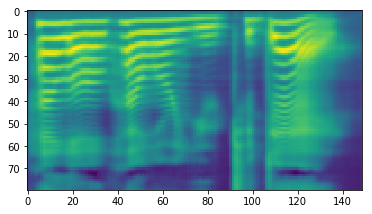

In [172]:
plt.imshow(mel.squeeze(0).detach().cpu().numpy())

In [173]:
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

In [174]:
Audio(audio_numpy, rate=rate)

## Speaker footprint

In [175]:
embedded_speaker = t2.speakers_embedding(speaker_id)

In [176]:
embedded_speaker

tensor([[ 4.5953e-03, -8.6826e-06,  1.5722e-03, -3.2818e-08,  3.9683e-06,
          3.2565e-02,  1.0630e-05, -1.2436e-05,  5.9308e-06, -2.1336e-02,
          1.0308e-05,  7.8969e-07,  2.0220e-06,  5.8132e-06, -7.2838e-06,
         -1.2582e-03]], device='cuda:0', grad_fn=<EmbeddingBackward>)